In [2]:
!pip install keras.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=539300a82a48f10aef27b10ec15a0205f5f27c6cfbf81edd80e53805a948cc08
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [3]:
!pip install tensorboardcolab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3859 sha256=875093164fd8f93ca0778a5ae9220b057f3d60f9ac2ccc0bf28a805ae801cb70
  Stored in directory: /root/.cache/pip/wheels/69/4e/4a/1c6c267395cb10edded1050df12af165d3254cfce324e80941
Successfully built tensorboardcolab


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tqdm import tqdm
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report
%matplotlib inline
warnings.filterwarnings("ignore")
from IPython.display import Image,YouTubeVideo,HTML

#KERAS Import
from keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers import Dense, Activation
from keras.layers import BatchNormalization
from keras.initializers import he_normal
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import Embedding, LSTM, GRU, Flatten, Input, concatenate, Conv1D, GlobalMaxPool1D, SpatialDropout1D, GlobalMaxPooling1D, Bidirectional, GlobalAveragePooling1D, add
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.initializers import Orthogonal
from keras.preprocessing.text import one_hot
from keras.constraints import max_norm
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

#for attention mechanism
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

In [5]:
df = pd.read_csv('/content/drive/MyDrive/data/Copy of final_dataset.csv', encoding= 'unicode_escape')
# df = pd.read_csv('/content/drive/MyDrive/data/train_toxicity_full_800mb.csv')
df.head()

,Unnamed: 0,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


**Data Cleaning**

In [6]:
print(df.iloc[28]['comment_text'])
print("Toxicity Level: ",df.iloc[28]['target'])

Thanks! We're really going to try  not only to improve civility, but also to make comments more dynamic and interesting.
Toxicity Level:  0.0


In [7]:
print(df.iloc[4]['comment_text'])
print("Toxicity Level: ",df.iloc[4]['target'])

haha you guys are a bunch of losers.
Toxicity Level:  0.893617021


In [8]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [10]:
# Combining all the above statemennts 
preprocessed_comments = []
# tqdm is for printing the status bar
for sentence in tqdm(df['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() )
    preprocessed_comments.append(sent.lower().strip())

100%|██████████| 50080/50080 [00:02<00:00, 20715.64it/s]


In [11]:

df['comment_text'] = preprocessed_comments

In [12]:
df['comment_text'][1]

'thank you this would make my life a lot less anxiety inducing keep it up and do not let anyone get in your way'

**EDA**

In [13]:
train_len = len(df.index)

In [14]:
miss_val_train_df = df.isnull().sum(axis=0) / train_len
miss_val_train_df = miss_val_train_df[miss_val_train_df > 0] * 100
miss_val_train_df

asian                                  74.754393
atheist                                74.754393
bisexual                               74.754393
black                                  74.754393
buddhist                               74.754393
christian                              74.754393
female                                 74.754393
heterosexual                           74.754393
hindu                                  74.754393
homosexual_gay_or_lesbian              74.754393
intellectual_or_learning_disability    74.754393
jewish                                 74.754393
latino                                 74.754393
male                                   74.754393
muslim                                 74.754393
other_disability                       74.754393
other_gender                           74.754393
other_race_or_ethnicity                74.754393
other_religion                         74.754393
other_sexual_orientation               74.754393
physical_disability 

**Distribution plot**

In [15]:
def plot_features_distribution(features, title):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        # This will find all the values which are not null so as to plot the ditribution
        sns.distplot(df.loc[~df[feature].isnull(),feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

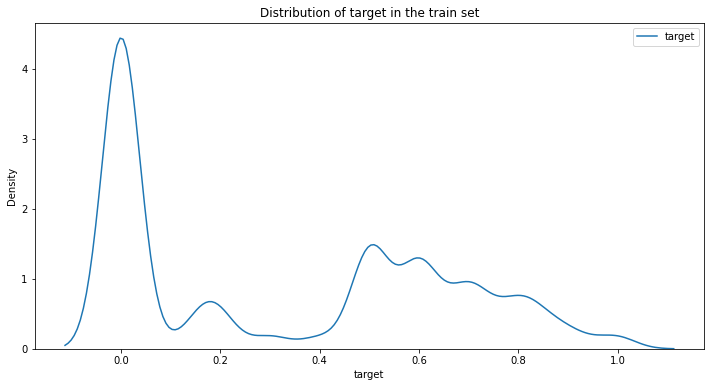

In [16]:
# Distribution of target variable
plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(df['target'],kde=True,hist=False, bins=120, label='target')
plt.legend()
plt.show()

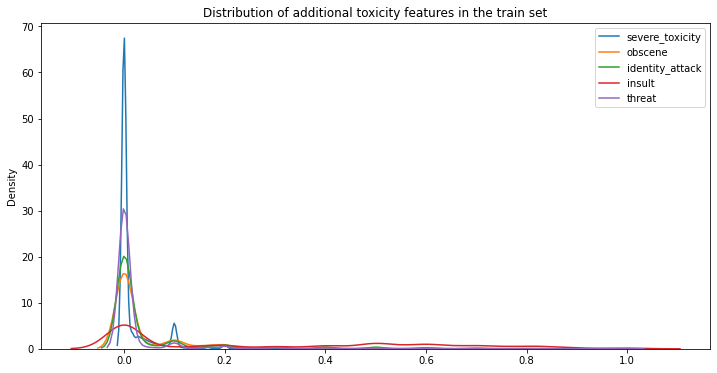

In [17]:
features = ['severe_toxicity', 'obscene','identity_attack','insult','threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set")

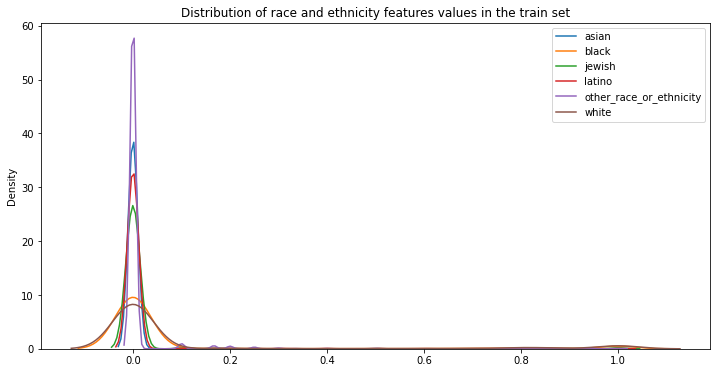

In [18]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set")

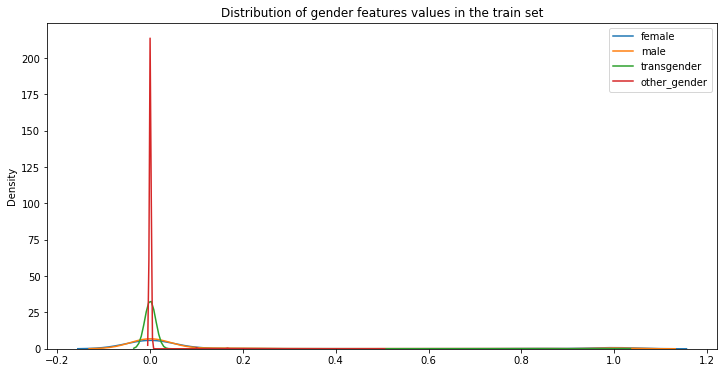

In [19]:
features = ['female', 'male', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender features values in the train set")

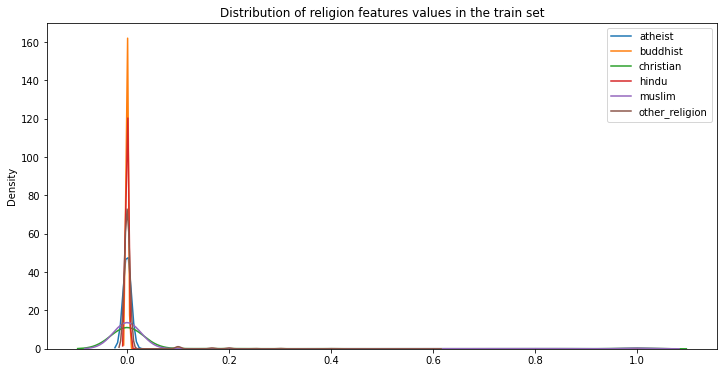

In [20]:
features = ['atheist','buddhist','christian', 'hindu', 'muslim', 'other_religion']
plot_features_distribution(features, "Distribution of religion features values in the train set")

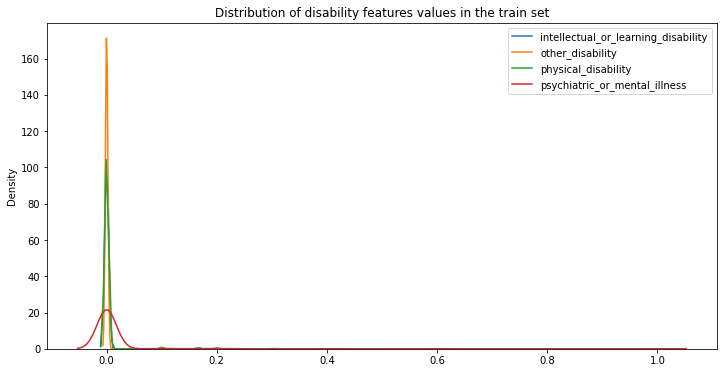

In [21]:
features = ['intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
plot_features_distribution(features, "Distribution of disability features values in the train set")

In [22]:
def make_wordcloud(comment_words,title):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
              min_font_size = 10,random_state=101,repeat=True).generate(str(comment_words)) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(title)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

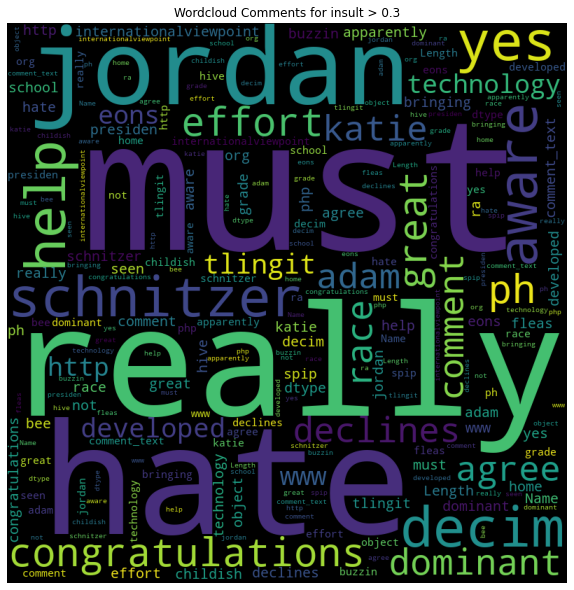

In [23]:
make_wordcloud(df.loc[df['insult'] < 0.3]['comment_text'].sample(10000),title='Wordcloud Comments for insult > 0.3')

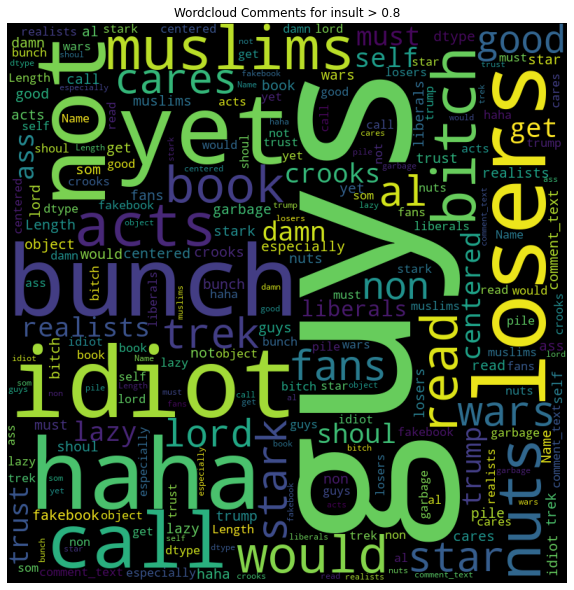

In [24]:
make_wordcloud(df.loc[df['insult'] > 0.8]['comment_text'],title='Wordcloud Comments for insult > 0.8')

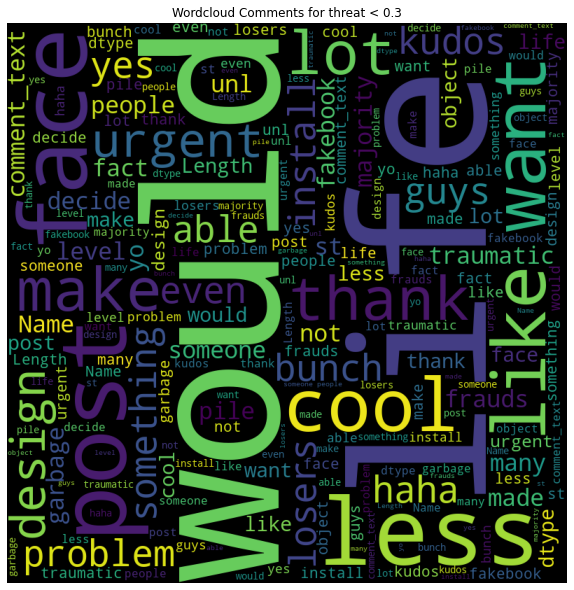

In [25]:
make_wordcloud(df.loc[df['threat'] < 0.3]['comment_text'],title='Wordcloud Comments for threat < 0.3')

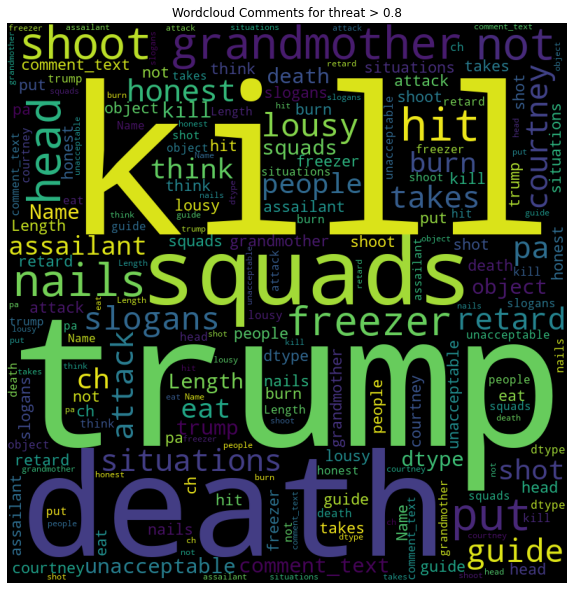

In [26]:
make_wordcloud(df.loc[df['threat'] > 0.8]['comment_text'],title='Wordcloud Comments for threat > 0.8')

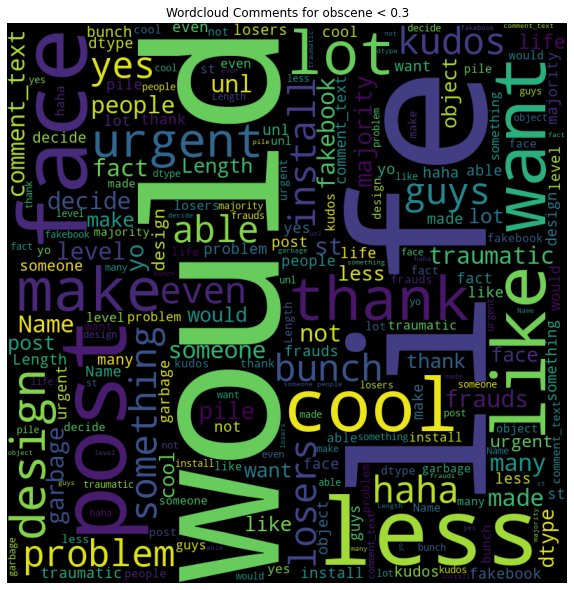

In [27]:
make_wordcloud(df.loc[df['obscene'] < 0.3]['comment_text'],title='Wordcloud Comments for obscene < 0.3')

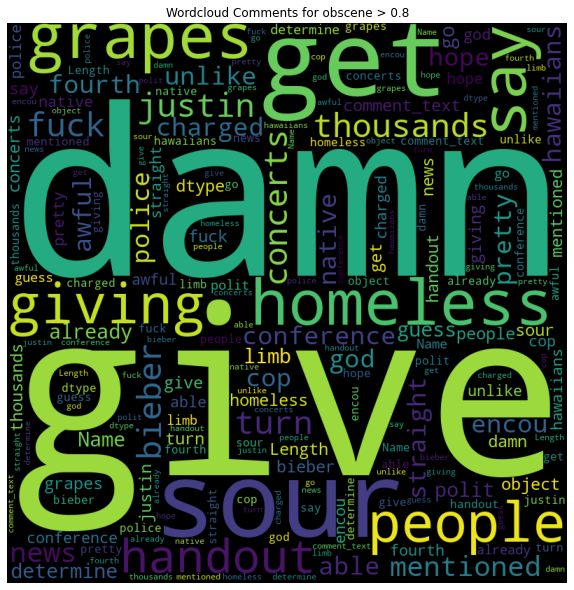

In [28]:
make_wordcloud(df.loc[df['obscene'] > 0.8]['comment_text'],title='Wordcloud Comments for obscene > 0.8')

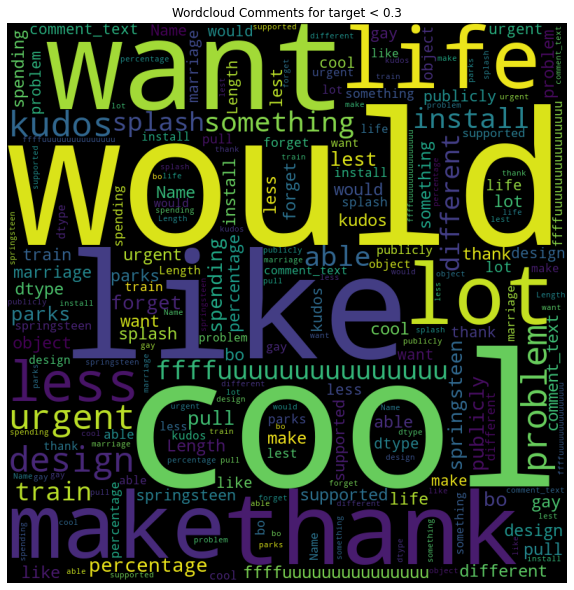

In [29]:
make_wordcloud(df.loc[df['target'] < 0.3]['comment_text'],title='Wordcloud Comments for target < 0.3')

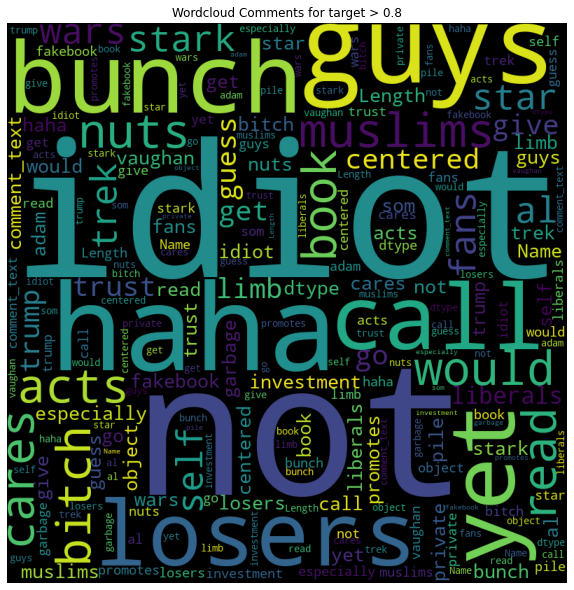

In [30]:
make_wordcloud(df.loc[df['target'] > 0.8]['comment_text'],title='Wordcloud Comments for target > 0.8')

DATA PREPROCESSING

In [31]:
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [32]:
for column in identity_columns + ['target']:
    df[column] = np.where(df[column] >= 0.5, True, False)

In [33]:
# Target variable as well
y = df['target'].values

In [34]:
# We will use tfidf and w2v to vectorize the words

In [35]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [36]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [37]:
x_train_tfidf = vectorizer.fit_transform(x_train["comment_text"])
x_test_tfidf = vectorizer.transform(x_test["comment_text"])

In [38]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix,index=class_names, columns=class_names
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [39]:
# Code help from Slack channel
def threshold_based_prediction(proba,threshold,tpr,fpr):
    thres = threshold[np.argmax(fpr*(1-tpr))]
    predictions = []
    for i in proba:
        if i>=thres:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

**Baseline - Logistic Regression model**

In [40]:
alpha = [10 ** x for x in range(-5, 2)]
auc_array_train=[]
auc_array_test=[]
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=5,class_weight='balanced')
  clf.fit(x_train_tfidf, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_train_tfidf, y_train)
    
    
  predict_y_train = sig_clf.predict_proba(x_train_tfidf)[:,1]
  predict_y_test = sig_clf.predict_proba(x_test_tfidf)[:,1]
  auc_array_train.append(roc_auc_score(y_train, predict_y_train))
  auc_array_test.append(roc_auc_score(y_test, predict_y_test))
  print('For values of alpha = ', i, "The auc score on CV is:",roc_auc_score(y_test, predict_y_test))

For values of alpha =  1e-05 The auc score on CV is: 0.9403400875247288
For values of alpha =  0.0001 The auc score on CV is: 0.9051091061686949
For values of alpha =  0.001 The auc score on CV is: 0.8547955358391782
For values of alpha =  0.01 The auc score on CV is: 0.8330809703654857
For values of alpha =  0.1 The auc score on CV is: 0.830893331734708
For values of alpha =  1 The auc score on CV is: 0.8335752652718662
For values of alpha =  10 The auc score on CV is: 0.8340269568171372


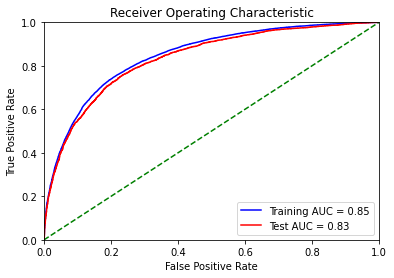

In [41]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr_train, tpr_train, threshold_train = roc_curve(y_train, predict_y_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, predict_y_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


plt.title('Receiver Operating Characteristic')

plt.plot(fpr_train, tpr_train, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'r', label = 'Test AUC = %0.2f' % roc_auc_test)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
clf = SGDClassifier(alpha=0.00001, penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(x_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_tfidf, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05,
                                                    class_weight='balanced',
                                                    loss='log',
                                                    random_state=42))

**RESULT**

In [43]:
predtrain = sig_clf.predict_proba(x_train_tfidf)[:,1]
predtest = sig_clf.predict_proba(x_test_tfidf)[:,1]

	TRAIN DATA CONFUSION MATRIX


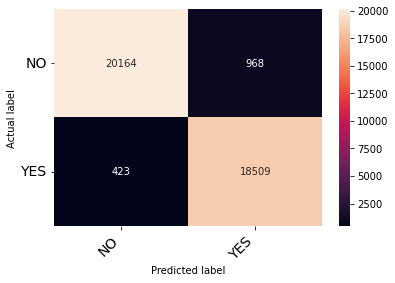

In [44]:
predtrain = threshold_based_prediction(predtrain,threshold_train,tpr_train,fpr_train)
cm = confusion_matrix(y_train, predtrain)
print("\tTRAIN DATA CONFUSION MATRIX")
print_confusion_matrix(cm,class_names=['NO','YES'])

	TEST DATA CONFUSION MATRIX


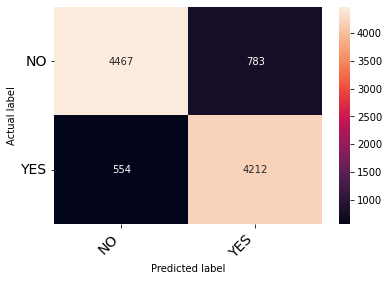

In [45]:
predtest = threshold_based_prediction(predtest,threshold_test,tpr_test,fpr_test)
cm = confusion_matrix(y_test, predtest)
print("\tTEST DATA CONFUSION MATRIX")
print_confusion_matrix(cm,class_names=['NO','YES'])

AUC scores

In [46]:
auc = roc_auc_score(y_train, predtrain)
print('\nTRAIN AUC on CV data is %f' % (auc))


TRAIN AUC on CV data is 0.965925


In [47]:
auc = roc_auc_score(y_test, predtest)
print('\nTEST AUC on Test data is %f' % (auc))


TEST AUC on Test data is 0.867309


F1 Score

In [48]:
print(classification_report(y_test,predtest))

              precision    recall  f1-score   support

       False       0.89      0.85      0.87      5250
        True       0.84      0.88      0.86      4766

    accuracy                           0.87     10016
   macro avg       0.87      0.87      0.87     10016
weighted avg       0.87      0.87      0.87     10016



**Metrics definition**

In [49]:
# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/90986#latest-527331
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive
TOXICITY_COLUMN = 'target'

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

In [50]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [51]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

**Preparing the text data for model**

In [52]:
MAX_VOCAB_SIZE = 100000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'
MAX_SEQUENCE_LENGTH = 300

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
def padding_text(texts, tokenizer):
    return sequence.pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

In [53]:
train_text = padding_text(x_train[TEXT_COLUMN], tokenizer)
train_y = to_categorical(x_train[TOXICITY_COLUMN])
test_text = padding_text(x_test[TEXT_COLUMN], tokenizer)
test_y = to_categorical(x_test[TOXICITY_COLUMN])

In [54]:
NUM_EPOCHS = 10
BATCH_SIZE = 512

In [55]:
# # https://fasttext.cc/docs/en/english-vectors.html
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

In [56]:
# !unzip crawl*.zip -d "/content/drive/MyDrive/data/toxicityFiles"

Embedding matrix


In [57]:
embeddings_index = {}
with open('/content/drive/MyDrive/data/toxicityFiles/crawl-300d-2M.vec' ,encoding='utf8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [58]:
len(tokenizer.word_index)

46752

In [59]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,300))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    num_words_in_embedding += 1
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

In [60]:
embedding_matrix.shape

(46753, 300)

**Using LSTM - Single LSTM layer architecture**

In [61]:
input_text_lstm = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedding_layer_lstm = Embedding(len(tokenizer.word_index) + 1,
                                    300,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
l = embedding_layer_lstm(input_text_lstm)
l = LSTM(128,return_sequences=True,dropout=0.5,kernel_regularizer=l2(0.001))(l)
l = Flatten()(l)
l = Dropout(0.5)(l)
l = Dense(128, activation='relu')(l)
lstm_output = Dense(2, activation='softmax')(l)

In [62]:
model = Model(inputs=[input_text_lstm], outputs=[lstm_output])

In [63]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [64]:
SLSTM_Model = model.fit(train_text,train_y,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(test_text, test_y))

Epoch 1/10
79/79 [==============================] - 431s 5s/step - loss: 0.6596 - accuracy: 0.7697 - val_loss: 0.4536 - val_accuracy: 0.8501
Epoch 2/10
79/79 [==============================] - 408s 5s/step - loss: 0.4518 - accuracy: 0.8359 - val_loss: 0.3817 - val_accuracy: 0.8656
Epoch 3/10
79/79 [==============================] - 415s 5s/step - loss: 0.4097 - accuracy: 0.8470 - val_loss: 0.3581 - val_accuracy: 0.8731
Epoch 4/10
79/79 [==============================] - 411s 5s/step - loss: 0.3841 - accuracy: 0.8542 - val_loss: 0.3558 - val_accuracy: 0.8678
Epoch 5/10
79/79 [==============================] - 416s 5s/step - loss: 0.3646 - accuracy: 0.8612 - val_loss: 0.3457 - val_accuracy: 0.8723
Epoch 6/10
79/79 [==============================] - 405s 5s/step - loss: 0.3546 - accuracy: 0.8657 - val_loss: 0.3593 - val_accuracy: 0.8641
Epoch 7/10
79/79 [==============================] - 409s 5s/step - loss: 0.3413 - accuracy: 0.8716 - val_loss: 0.3451 - val_accuracy: 0.8689
Epoch 8/10
79

In [65]:
# Prediction on test data
MODEL_NAME = 'slstm_model'
x_test[MODEL_NAME] = model.predict(test_text)[:, 1]

In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(x_test, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

In [67]:
get_final_metric(bias_metrics_df, calculate_overall_auc(x_test, MODEL_NAME))

0.8908690328841582

In [68]:
data = {'text': ['it is such a beautiful day', 'its a beautiful day for you to die']}
dframe = pd.DataFrame(data)
zz_text = padding_text(dframe["text"], tokenizer)

In [69]:
model.predict(zz_text)[:, 1]

array([0.04415723, 0.85824496], dtype=float32)